# Dimensionality Reduction

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

We will continue to work with the Crime data introduced in Week 8

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline

# Load some crime data
headers = pd.read_csv('comm_names.txt', squeeze=True)
headers = headers.apply(lambda s: s.split()[1])
crime = (pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data', 
                    header=None, na_values=['?'], names=headers)
         .iloc[:, 5:]
         .dropna()
         )

# Set target and predictors
target = 'ViolentCrimesPerPop'
predictors = [c for c in crime.columns if not c == target]

# Train/test split
X = crime[predictors]
y = crime[[target]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [3]:
X_train.shape

(239, 121)

In [4]:
X_train.head()

,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
54,0.23,0.28,0.76,0.08,0.01,0.32,0.37,0.22,0.61,0.09,...,0.46,0.08,0.16,0.29,0.09,0.01,0.56,0.0,1.00,0.12
41,0.58,0.01,0.83,0.13,0.21,0.44,0.49,0.29,0.25,0.06,...,0.11,0.05,0.16,0.20,0.06,0.04,0.22,0.5,0.59,0.48
13,0.47,0.74,0.37,0.08,0.05,0.49,0.57,0.40,0.34,0.27,...,0.00,0.63,0.07,0.08,0.37,0.04,0.74,0.5,0.84,0.09
1,0.45,0.83,0.34,0.04,0.01,0.48,0.53,0.36,0.37,0.30,...,0.07,0.39,0.12,0.09,0.04,0.01,0.00,0.0,0.36,0.01
19,0.43,0.04,0.89,0.09,0.06,0.45,0.48,0.31,0.46,0.13,...,0.29,0.16,0.12,0.07,0.04,0.01,0.81,1.0,0.56,0.09


In Week five we build a linear model with this data. The problem was that there were too many variables and so it was too easy to overfit. We used regularization to solve this problem.

This week, we will use a different strategy. Instead of regularization, we will reduce overfitting by reducing the number of variables that are used in the model. First, we will make sure we understand how to use PCA.

### Learn the principal components of the training data

First lets look at the covariance of the training data, which tells us about the relationships between the various variables.

In [5]:
covar = X_train.cov()
covar.head()

,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
householdsize,0.021410,-0.000127,-0.011699,0.007105,0.022312,0.008448,0.005489,0.003611,-0.013051,0.000907,...,0.004106,0.000477,0.003530,-0.003442,-0.002739,-0.000461,0.000065,0.003671,-0.002352,-0.004670
racepctblack,-0.000127,0.092122,-0.062022,-0.023163,-0.016497,0.010070,0.006355,0.007921,-0.001788,0.008230,...,-0.009082,0.005963,0.002844,0.019239,0.012588,0.004061,-0.012726,0.007832,0.007020,-0.000865
racePctWhite,-0.011699,-0.062022,0.061215,-0.005825,-0.014351,-0.010141,-0.008796,-0.007804,0.010488,-0.012800,...,-0.002211,-0.004517,-0.017188,-0.020940,-0.009573,-0.005864,0.007443,-0.012998,-0.006491,0.002158
racePctAsian,0.007105,-0.023163,-0.005825,0.056827,0.016331,-0.002698,0.003220,0.000884,-0.010732,0.008682,...,0.014028,-0.001759,0.018240,0.011425,-0.003540,0.004182,0.005368,0.010434,-0.001469,-0.000444
racePctHisp,0.022312,-0.016497,-0.014351,0.016331,0.063348,0.004709,0.005313,0.001569,-0.011534,0.006021,...,0.013533,-0.003201,0.027619,0.008045,0.002171,0.003755,0.003162,0.006303,0.001483,-0.000006


Total Variance

In [6]:
np.trace(covar)

4.5646812840617415

Now lets transform the data into principal component space.

In [7]:
pca = PCA()
X_transformed = pca.fit_transform(X_train)

In [11]:
pd.DataFrame(X_transformed).head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,-0.835436,-0.782788,-0.240360,-0.546547,0.155633,0.413783,0.031923,0.164605,0.571219,-0.375413,...,0.002787,-0.009088,-0.006674,0.001066,0.002344,-0.001072,-0.004996,0.002008,-0.001231,0.000531
1,0.482213,-0.533173,-0.427922,0.475401,-0.271597,0.056032,-0.056781,0.200377,-0.640000,0.674431,...,0.000891,-0.015754,0.002402,0.002503,-0.002733,-0.005956,0.002562,-0.001938,-0.001192,-0.000249
2,-0.958639,-0.132297,0.116940,0.438736,-0.216893,-0.211926,0.305924,0.308060,-0.007235,-0.230562,...,-0.008031,-0.003205,0.000035,-0.003474,-0.000604,-0.000791,0.002741,-0.005113,0.002432,0.000446
3,-1.112468,-0.161564,0.005551,0.184264,-0.042920,-0.892427,0.541019,0.592848,0.461473,-0.163100,...,-0.005494,0.004937,-0.003637,0.000213,0.001290,-0.000079,-0.001456,-0.005941,-0.002815,-0.000394
4,-0.465933,-0.782386,-0.341636,0.523286,0.042809,0.104373,-0.545111,-0.626676,0.008542,0.215413,...,0.005067,-0.007544,-0.002542,-0.003181,-0.002574,-0.001933,0.000923,-0.008091,-0.001164,-0.000052


What does the covariance look like now?

In [13]:
new_covar = pd.DataFrame(X_transformed).cov()
new_covar.head().round(3)

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,1.0,0.000,0.000,0.000,-0.000,-0.0,0.0,0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0
1,0.0,0.945,0.000,-0.000,-0.000,0.0,0.0,-0.0,0.0,-0.0,...,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0
2,0.0,0.000,0.366,0.000,0.000,0.0,0.0,-0.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
3,0.0,-0.000,0.000,0.341,-0.000,0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0
4,-0.0,-0.000,0.000,-0.000,0.229,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0


What about the total variance?

In [14]:
np.trace(new_covar)

4.5646812840617423

The explained variance is also an attribute of the PCA object

In [16]:
np.round(pca.explained_variance_, 3)

array([ 0.996,  0.941,  0.365,  0.34 ,  0.228,  0.19 ,  0.163,  0.148,
        0.107,  0.095,  0.077,  0.07 ,  0.057,  0.053,  0.051,  0.044,
        0.042,  0.039,  0.037,  0.035,  0.03 ,  0.029,  0.027,  0.025,
        0.023,  0.021,  0.019,  0.017,  0.017,  0.015,  0.014,  0.014,
        0.013,  0.012,  0.011,  0.011,  0.01 ,  0.009,  0.009,  0.008,
        0.008,  0.007,  0.007,  0.006,  0.006,  0.006,  0.005,  0.005,
        0.005,  0.005,  0.004,  0.004,  0.004,  0.004,  0.003,  0.003,
        0.003,  0.003,  0.003,  0.003,  0.002,  0.002,  0.002,  0.002,
        0.002,  0.002,  0.002,  0.002,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
      

### Exercise

A typical rule of thumb is to keep the components that account for 90% of the total variance. Use PCA to create a new data frame X_reduced. The total variance in the columns of X_reduced should account for about 90% of the variance in X_train

Fit PCA to the training data

In [17]:
pca = PCA().fit(X_train)

Scree plot of explained variance

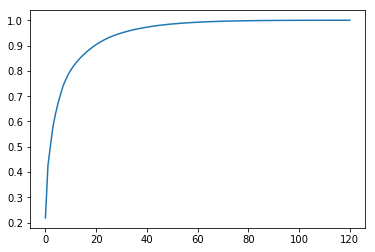

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

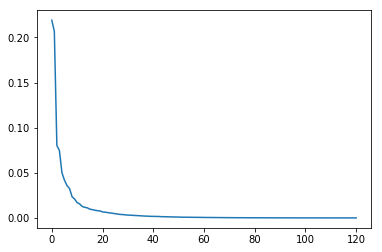

In [21]:
plt.plot(pca.explained_variance_ratio_)

Decide how many components to use

In [24]:
num_comp = np.sum(np.cumsum(pca.explained_variance_ratio_) < .9)
num_comp

20

There are at least three different ways to use this PCA object to reduce the dimension of the data. It is instructive to go through all three options.

#### Method One

Create a new PCA object that is explicity a dimension reducer

In [25]:
X_reduced = PCA(n_components=20).fit_transform(X_train)

In [26]:
X_reduced.shape

(239, 20)

In [27]:
X_reduced[:5, :5]

array([[-0.83543565, -0.78278795, -0.24035994, -0.54654713,  0.15563304],
       [ 0.48221287, -0.5331727 , -0.42792212,  0.47540061, -0.27159707],
       [-0.95863882, -0.13229706,  0.11693975,  0.43873554, -0.21689277],
       [-1.11246824, -0.16156369,  0.00555115,  0.18426371, -0.04292035],
       [-0.46593257, -0.78238634, -0.34163554,  0.5232864 ,  0.04280874]])

#### Method Two

Transform the data using the original PCA, but keep only the first num_comp columns

In [28]:
X_reduced = PCA().fit_transform(X_train)[:, :20]

In [29]:
X_reduced.shape

(239, 20)

In [30]:
X_reduced[:5, :5]

array([[-0.83543565, -0.78278795, -0.24035994, -0.54654713,  0.15563304],
       [ 0.48221287, -0.5331727 , -0.42792212,  0.47540061, -0.27159707],
       [-0.95863882, -0.13229706,  0.11693975,  0.43873554, -0.21689277],
       [-1.11246824, -0.16156369,  0.00555115,  0.18426371, -0.04292035],
       [-0.46593257, -0.78238634, -0.34163554,  0.5232864 ,  0.04280874]])

#### Method Three

The key to understanding PCA is the following equation:

$$
\underset{m \times n}M \approx \underset{m \times k}U \times \underset{k \times n}V^T
$$

- $M$ is the original data matrix (as long as each column has zero mean)
- $k$ is the dimension to reduce to
- $U$ maps from rows of M to components
- $V^T$ maps from components to columns of M (features)

In [31]:
pca = PCA().fit(X_train)

In [33]:
pca.components_.shape

(121, 121)

In [34]:
M = X_train - X_train.mean()
Vt = pca.components_[:20, :]
U = np.matmul(M, np.transpose(Vt))

In [35]:
U.shape

(239, 20)

In [36]:
U[:5, :5]

array([[-0.83543565, -0.78278795, -0.24035994, -0.54654713,  0.15563304],
       [ 0.48221287, -0.5331727 , -0.42792212,  0.47540061, -0.27159707],
       [-0.95863882, -0.13229706,  0.11693975,  0.43873554, -0.21689277],
       [-1.11246824, -0.16156369,  0.00555115,  0.18426371, -0.04292035],
       [-0.46593257, -0.78238634, -0.34163554,  0.5232864 ,  0.04280874]])

### Exercise

The component matrix $V$ tells us the mapping between principal components and the original features. Use this matrix to try to interpret the first two principal components

In [41]:
comp1 = pd.Series(dict(zip(X_train.columns, pca.components_[1, :])))
comp1.sort_values(ascending=False)

PctNotSpeakEnglWell    0.206046
PctIlleg               0.191114
PctPersDenseHous       0.191065
racePctHisp            0.180157
PctRecImmig10          0.175007
PctLargHouseFam        0.174359
pctWPubAsst            0.173927
PctRecImmig8           0.170854
PctRecImmig5           0.167628
PctRecentImmig         0.161552
PctWOFullPlumb         0.160409
PopDens                0.160108
PctForeignBorn         0.152902
PctLargHouseOccup      0.149430
PctLess9thGrade        0.146794
PctPolicMinor          0.141652
PctUnemployed          0.137359
PctNotHSGrad           0.133515
PctPopUnderPov         0.131821
PctUsePubTrans         0.128574
NumUnderPov            0.122033
racepctblack           0.116232
NumIlleg               0.113874
PctVacantBoarded       0.109888
PctHousNoPhone         0.108616
PersPerRentOccHous     0.106511
PersPerFam             0.105481
PctPolicHisp           0.103649
NumImmig               0.099158
MalePctNevMarr         0.095950
                         ...   
pctWWage

## Application: Linear Regression

We tried regularized regression on this dataset before. Let's remind ourselves of the results

#### Vanilla

In [42]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

print 'Train R-squared: {:.3}'.format(lr.score(X_train, y_train))
print 'Test R-squared: {:.3}'.format(lr.score(X_test, y_test))

Train R-squared: 0.823
Test R-squared: 0.509


#### Lasso

In [43]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(alphas= 2. ** np.arange(-10, 10))
lasso.fit(X_train, y_train)

print 'Train R-squared: {:.3}'.format(lasso.score(X_train, y_train))
print 'Test R-squared: {:.3}'.format(lasso.score(X_test, y_test))

Train R-squared: 0.661
Test R-squared: 0.722


/Users/zalexander/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Using Dimensionality Reduction

The reason the un-regularized model does so poorly is that there are way too many features compared to the number of observations. Another approach to regularization is simply to choose a smaller number of features.

## Exercise

Below are three approaches to reducing the number of features used in the model. For each approach, 

1. Plot the R-squared (on X_test) vs number of features used.
2. Report the best R-squared
3. Report the number of features used to get the best R-squared

#### 1. Randomly choose subsets of features

This is the most naive approach to dimensionality reduction; just pick $k$ features at random.

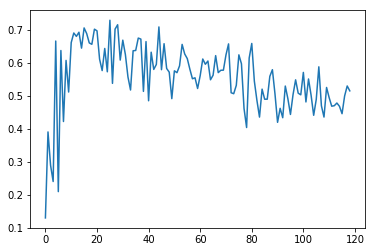

In [44]:
def random_features(nfeatures):
    cols = np.random.choice(X_train.columns, nfeatures, replace=False)
    lr = LinearRegression()
    lr.fit(X_train.loc[:, cols], y_train)
    return lr.score(X_test.loc[:, cols], y_test)

out = [random_features(i) for i in range(1, 120)]
plt.plot(out)

In [45]:
np.max(out)

0.7290559561325578

In [47]:
np.argmax(out)

25

#### 2. Intelligently choose subsets of features

We can do a little better than randomly choosing sets of features. Use the sklearn function `f_regression` to rank the features in order of their correlation with the target, then pick the top $k$ features.

#### 3. Intelligently choose a projections into principal component space

Lastly, we can use PCA to compress as much information into as few features as possible. The number of features to use is the number of principal components.